<hr style="border: 4.5px solid teal;" />
<hr style="border: 3.3px solid #10b981;" />   <!-- Emerald -->

<H1 style="text-align: center;"> Spam/Ham Classification Part 2 $\rightarrow$ Build the Model:  </H1>
<h2 style="text-align: center;"> Feature Engineering, Classification and Cross-Validation </h2>

<hr style="border: 2.2px solid teal;" />
<hr style="border: 2px solid cornflowerblue;" />

## Introduction
**Goal**: Create a binary classifier that can distinguish spam (junk, commercial, or bulk) emails from ham (regular non-spam) emails.

Part 1, includes the following:

- Feature engineering with text data.
- Using the `sklearn` library to process data and fit models.
- Validating the performance of our model and minimizing overfitting.

This Part 1, focuses on initial data analysis, feature engineering, and logistic regression. 
Part 2 of this project, I build a spam/ham classifier.

***Warning*** This is a **real-world** dataset so the emails are actual spam and legitimate emails. As a result, some of the spam emails may be in poor taste or be considered inappropriate.

## Introduction
In this project, we will build and improve on the concepts and functions we implemented in Part 1 to create our own classifier and distinguish spam emails from ham (non-spam) emails. \

Part 2, includes the following:

- Using `sklearn` libraries to process data and fit classification models.
- Validating the performance of our model and minimizing overfitting.
- Generating and analyzing ROC curves.



## Importing Modules

In [1]:
import numpy as np
import pandas as pd
import sys

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

from datetime import datetime
from IPython.display import display, HTML

In [13]:
working_dir = !pwd
if working_dir[0].split('/')[1]=='EmilieCote':
    HOME_DIR = True
    

<hr style="border: 4.5px solid teal;" />
<hr style="border: 3.3px solid #10b981;" />   <!-- Emerald -->
<hr style="border: 2.2px solid teal;" />
<hr style="border: 2px solid cornflowerblue;" />

# Setup and Recap

Here is a summary of Part 1 to remind us of how we cleaned the data, explored it, and implemented methods helpful in building our own model.

## Loading and Cleaning Data

Remember that in the email classification task, our goal is to classify emails as spam or not spam (referred to as "ham") using features generated from the text in the email. 

The dataset consists of email messages and their labels (0 for ham, 1 for spam). Our labeled training dataset contains 8,348 labeled examples, and the unlabeled test set contains 1,000 unlabeled examples.

Run the following cell to load the data into a `DataFrame`.

The `train` `DataFrame` contains labeled data that we will use to train our model. It contains four columns:

1. `id`: An identifier for the training example.
1. `subject`: The subject of the email.
1. `email`: The text of the email.
1. `spam`: 1 if the email is spam, 0 if the email is ham (not spam).

The `test` `DataFrame` contains 1,000 unlabeled emails. We will predict labels for these emails.

In [2]:
import zipfile
with zipfile.ZipFile('../spam_ham_data.zip') as item:
    with item.open("train.csv") as f:
        original_training_data = pd.read_csv(f)
    with item.open("test.csv") as f:
        test = pd.read_csv(f)
import zipfile

In [3]:
# Convert the emails to lowercase as the first step of text processing.
original_training_data['email'] = original_training_data['email'].str.lower()
test['email'] = test['email'].str.lower()

original_training_data.head()

,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


Feel free to explore the dataset above along with any specific spam and ham emails of interest. Keep in mind that our data may contain missing values, which are handled in the following cell.

In [4]:
# Fill any missing or NAN values.
print('Before imputation:')
print(original_training_data.isnull().sum())
original_training_data = original_training_data.fillna('')
print('------------')
print('After imputation:')
print(original_training_data.isnull().sum())

Before imputation:
id         0
subject    6
email      0
spam       0
dtype: int64
------------
After imputation:
id         0
subject    0
email      0
spam       0
dtype: int64


## Training/Validation Split

Recall that the training data we downloaded is all the data we have available for both training models and **validating** the models that we train. Therefore, we split the training data into separate training and validation datasets. Once we have finished training, we will need this validation data to assess the performance of our classifier. 

To be consistent with Part 1, we set the seed (`random_state`) to 42 again. 

In [11]:
# This creates a 90/10 train-validation split on our labeled data.
from sklearn.model_selection import train_test_split
train, val = train_test_split(original_training_data, test_size = 0.1, random_state = 42)

# We must do this in order to preserve the ordering of emails to labels for words_in_texts.
train = train.reset_index(drop = True)

<hr style="border: 4.5px solid teal;" />
<hr style="border: 3.3px solid #10b981;" />   <!-- Emerald -->
<hr style="border: 2.2px solid teal;" />
<hr style="border: 2px solid cornflowerblue;" />

## Feature Engineering

We need a numeric feature matrix $\mathbb{X}$ and a vector of corresponding binary labels $\mathbb{Y}$ to train a logistic regression model. In Project B1, we implemented the function `words_in_texts`, which creates numeric features derived from the email text and uses those features for logistic regression. 


In [ ]:
!pwd

In [18]:
def words_in_texts(words, texts):
    """
    Args:
        words (list): Words to find.
        texts (Series): Strings to search in.
    
    Returns:
        A 2D NumPy array of 0s and 1s with shape (n, d) where 
        n is the number of texts, and d is the number of words.
    """
    indicator_array = np.array([texts.str.contains(word).astype(int) for word in words]).T
    return indicator_array

words_in_texts(['hello', 'bye', 'world'], pd.Series(['hello', 'hello worldhello']))

array([[1, 0, 0],
       [1, 0, 1]])

<hr style="border: 5px solid hsl(200, 100%, 50%);" />   <!-- bright blue -->
<hr style="border: 4.5px solid teal;" />
<hr style="border: 3.3px solid #10b981;" />   <!-- Emerald -->
<hr style="border: 2.2px solid teal;" />
<hr style="border: 2px solid cornflowerblue;" />


## EDA and Basic Classification

In Email Classification Part 1, we visualized the frequency of different words in spam and ham emails and used `words_in_texts(words, train['email'])` to train a classifier directly. We also used a simple set of 5 words that might be useful as features to distinguish spam/ham emails. 

We then built a model using the [`LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier from `sklearn`.

Run the following cell to see the performance of a simple model using these words and the `train` `DataFrame`.

In [15]:
some_words = ['drug', 'bank', 'prescription', 'memo', 'private']

X_train = words_in_texts(some_words, train['email'])
Y_train = np.array(train['spam'])

X_train[:5], Y_train[:5]

(array([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0]]),
 array([0, 0, 0, 0, 0]))

In [22]:
from sklearn.linear_model import LogisticRegression

simple_model = LogisticRegression()
simple_model.fit(X_train, Y_train)

training_accuracy = simple_model.score(X_train, Y_train)
print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.7576201251164648


<hr style="border: 4.5px solid teal;" />
<hr style="border: 3.3px solid #10b981;" />   <!-- Emerald -->
<hr style="border: 2.2px solid teal;" />
<hr style="border: 2px solid cornflowerblue;" />
<hr style="border: 5px solid hsl(200, 100%, 50%);" />   <!-- bright blue -->

## Evaluating Classifiers  

In our models, we evaluate the accuracy of the training set, which may provide a misleading accuracy measure. In Project B1, we calculated various metrics to consider other ways of evaluating a classifier, in addition to overall accuracy. Below is a reference to those concepts.

Presumably, our classifier will be used for **filtering**, or preventing messages labeled `spam` from reaching someone's inbox. There are two kinds of errors we can make:
- **False positive (FP)**: A ham email gets flagged as spam and filtered out of the inbox.
- **False negative (FN)**: A spam email gets mislabeled as ham and ends up in the inbox.

To be clear, we label spam emails as 1 and ham emails as 0. These definitions depend both on the true labels and the predicted labels. False positives and false negatives may be of differing importance, leading us to consider more ways of evaluating a classifier in addition to overall accuracy:

**Precision**: Measures the proportion of emails flagged as spam that are actually spam. Mathematically, $\frac{\text{TP}}{\text{TP} + \text{FP}}$.

**Recall**: Measures the proportion  of spam emails that were correctly flagged as spam. Mathematically, $\frac{\text{TP}}{\text{TP} + \text{FN}}$.

**False positive rate**: Measures the proportion  of ham emails that were incorrectly flagged as spam. Mathematically, $\frac{\text{FP}}{\text{FP} + \text{TN}}$.

The below graphic (modified slightly from [Wikipedia](https://en.wikipedia.org/wiki/Precision_and_recall)) can help us understand precision and recall visually:<br />
<center>
<img alt="precision_recall" src="precision_recall.png" width="600px;" />
</center>

Note that a True Positive (TP) is a spam email that is classified as spam, and a True Negative (TN) is a ham email that is classified as ham.

<br/>
<hr style="border: 4.5px solid teal;" />
<hr style="border: 3.3px solid #10b981;" />   <!-- Emerald -->
<hr style="border: 2.2px solid teal;" />
<hr style="border: 2px solid cornflowerblue;" />
<hr style="border: 5px solid hsl(200, 100%, 50%);" />   <!-- bright blue -->

# Moving Forward

With this in mind, it is now our task to make the spam filter more accurate.

Here are some ideas for improving our model:

1. Finding better features based on the email text. Some example features are:
    1. Number of characters in the subject/body
    1. Number of words in the subject/body
    1. Use of punctuation (e.g., how many '!'s were there?)
    1. Number/percentage of capital letters 
    1. Whether the email is a reply to an earlier email or a forwarded email
1. Finding better words to use as features. Which words are the best at distinguishing emails? This requires digging into the email text itself. Alternatively, you can identify misclassified emails and see which relevant words are missing in our model.
1. Reducing dimensionality and/or multicollinearity. There are a few methods to achieve this:
    1. Interpret the model coefficients. Note that a feature will be more valuable in classification if its coefficient has a larger **absolute** value. If the coefficient has a lower **absolute** value, the feature likely isn't valuable in classifying emails.
1. Better data processing. For example, many emails contain HTML as well as text. You can consider extracting the text from the HTML to help you find better words. Or, you can match HTML tags themselves, or even some combination of the two.
1. Model selection. You can adjust the parameters of our model (e.g. the penalty type, the regularization parameter, or any arguments in `LogisticRegression`) to achieve higher accuracy. Recall that you should use cross-validation for feature and model selection! Otherwise, you will likely overfit to our training data.
    1. Consider implementing L1 regularization. The [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) for `LogisticRegression` may be helpful here. 
    1. We have imported `GridSearchCV` for you. You may use sklearn's `GridSearchCV` ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)) class to perform cross-validation. You do not need to code cross-validation from scratch, though you are welcome to do so.

Here's an example of how to use `GridSearchCV`. Suppose we wanted to experiment with 4 different solvers (numerical methods for optimizing the mode) models for a `LogisticRegression` model `lr_model`. 
1. We could define a dictionary specifying the hyperparameters and the specific values we want to try out like so: `parameters = {'solver':[{'lbfgs', 'liblinear', 'newton-cg', 'saga']}`.
2. Running `grid = GridSearchCV(estimator=lr_model, param_grid=parameters)` would give us a model for each combination of hyperparameters we are testing - in this case, just 4 models.
3. We fit each model to some training data `X_train` and `Y_train` using `grid_result = grid.fit(X_train, Y_train)`.
4. Indexing into `grid_result.cv_results_` with a particular metric (in this case, `mean_test_score`), we get an array with the scores corresponding to each of the models. `grid_result.cv_results_['mean_test_score']`.
Feel free to experiment with other hyperparameters and metrics as well. The documentation is our friend!     
       
You may use whatever method you prefer to create features, but **you may only use the packages we've imported for you in the cell below or earlier in this notebook**. In addition, **you are only allowed to train logistic regression models**. No decision trees, random forests, k-nearest-neighbors, neural nets, etc. 

**Note 1:** You may want to use our **validation data** to evaluate our model and get a better sense of how it will perform on the test set. However, you may overfit to our validation set if you try to optimize our validation accuracy too much. Alternatively, you can perform cross-validation on the entire training set.

**Note 2:** If you see a `ConvergenceWarning`, increase the maximum number of iterations the model runs for by passing in a parameter, `max_iter`, into `LogisticRegression()`. This should get rid of the warning. For a longer discussion on why this warning appears, you might find [this StackOverflow post](https://stackoverflow.com/questions/62658215/convergencewarning-lbfgs-failed-to-converge-status-1-stop-total-no-of-iter) helpful. Convergence of solvers is not in scope for Data 100, but by understanding what the error messages are saying, you can get some useful context on what to do in these situations.

<br/>
<hr style="border: 4.5px solid teal;" />
<hr style="border: 3.3px solid #10b981;" />   <!-- Emerald -->
<hr style="border: 2.2px solid teal;" />
<hr style="border: 2px solid cornflowerblue;" />
<hr style="border: 5px solid hsl(200, 100%, 50%);" />   <!-- bright blue -->

# 1: Exploratory Data Analysis

To decide which features to use when building our model, it is helpful to conduct EDA. Show a visualization you used to select features for our model. 

Please include:

1. A plot showing something meaningful about the data that helped you during feature selection, model selection, or both.
2. Two or three sentences describing what you plotted and its implications with respect to our features.

You can create as many plots as you want in our feature selection process, but you should select only one for the response question below.

Here are some ideas:

1. Consider the correlation between multiple features (look up correlation plots and `sns.heatmap` ([documentation](https://seaborn.pydata.org/generated/seaborn.heatmap.html))). 
1. Try to show redundancy in a group of features (e.g., `body` and `html` might co-occur relatively frequently, or you might be able to design a feature that captures all HTML tags and compares them to these). 
1. Visualize which words have high or low values for helpful statistics.
1. Visually depict whether spam emails tend to be wordier (in some sense) than ham emails.

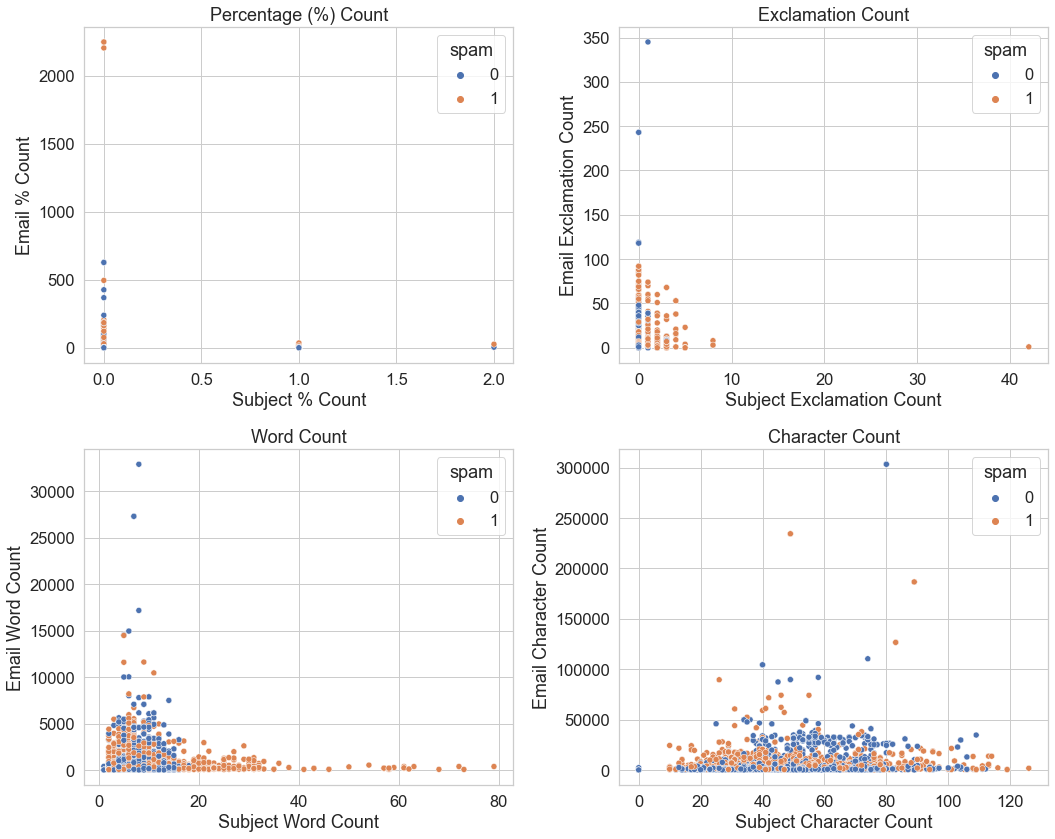

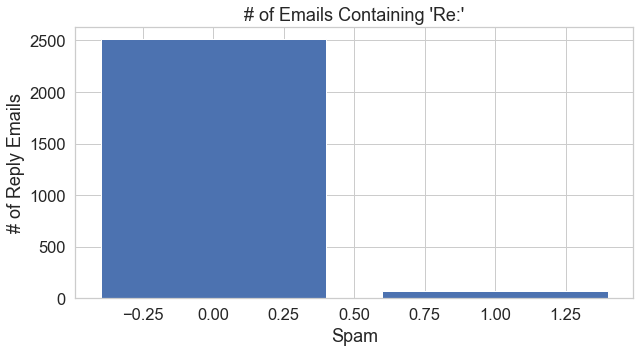

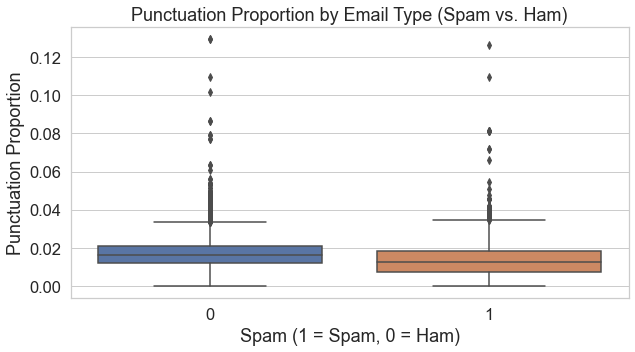

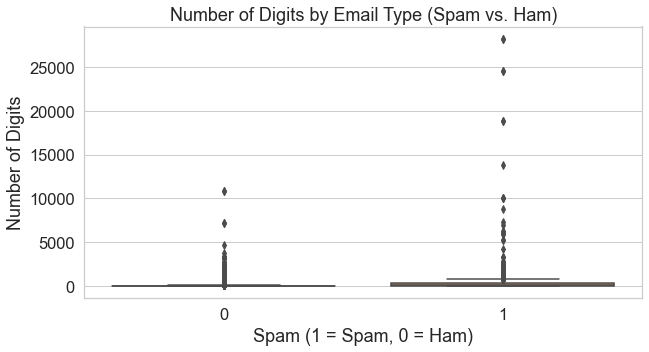

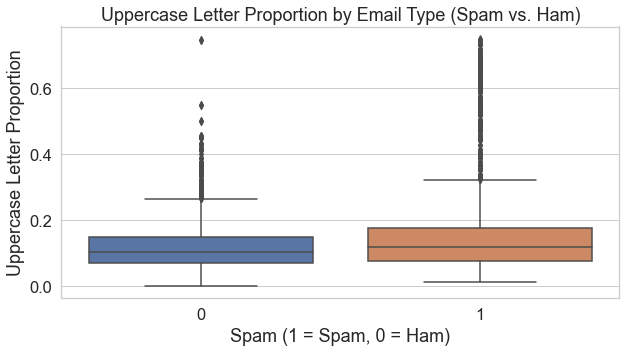

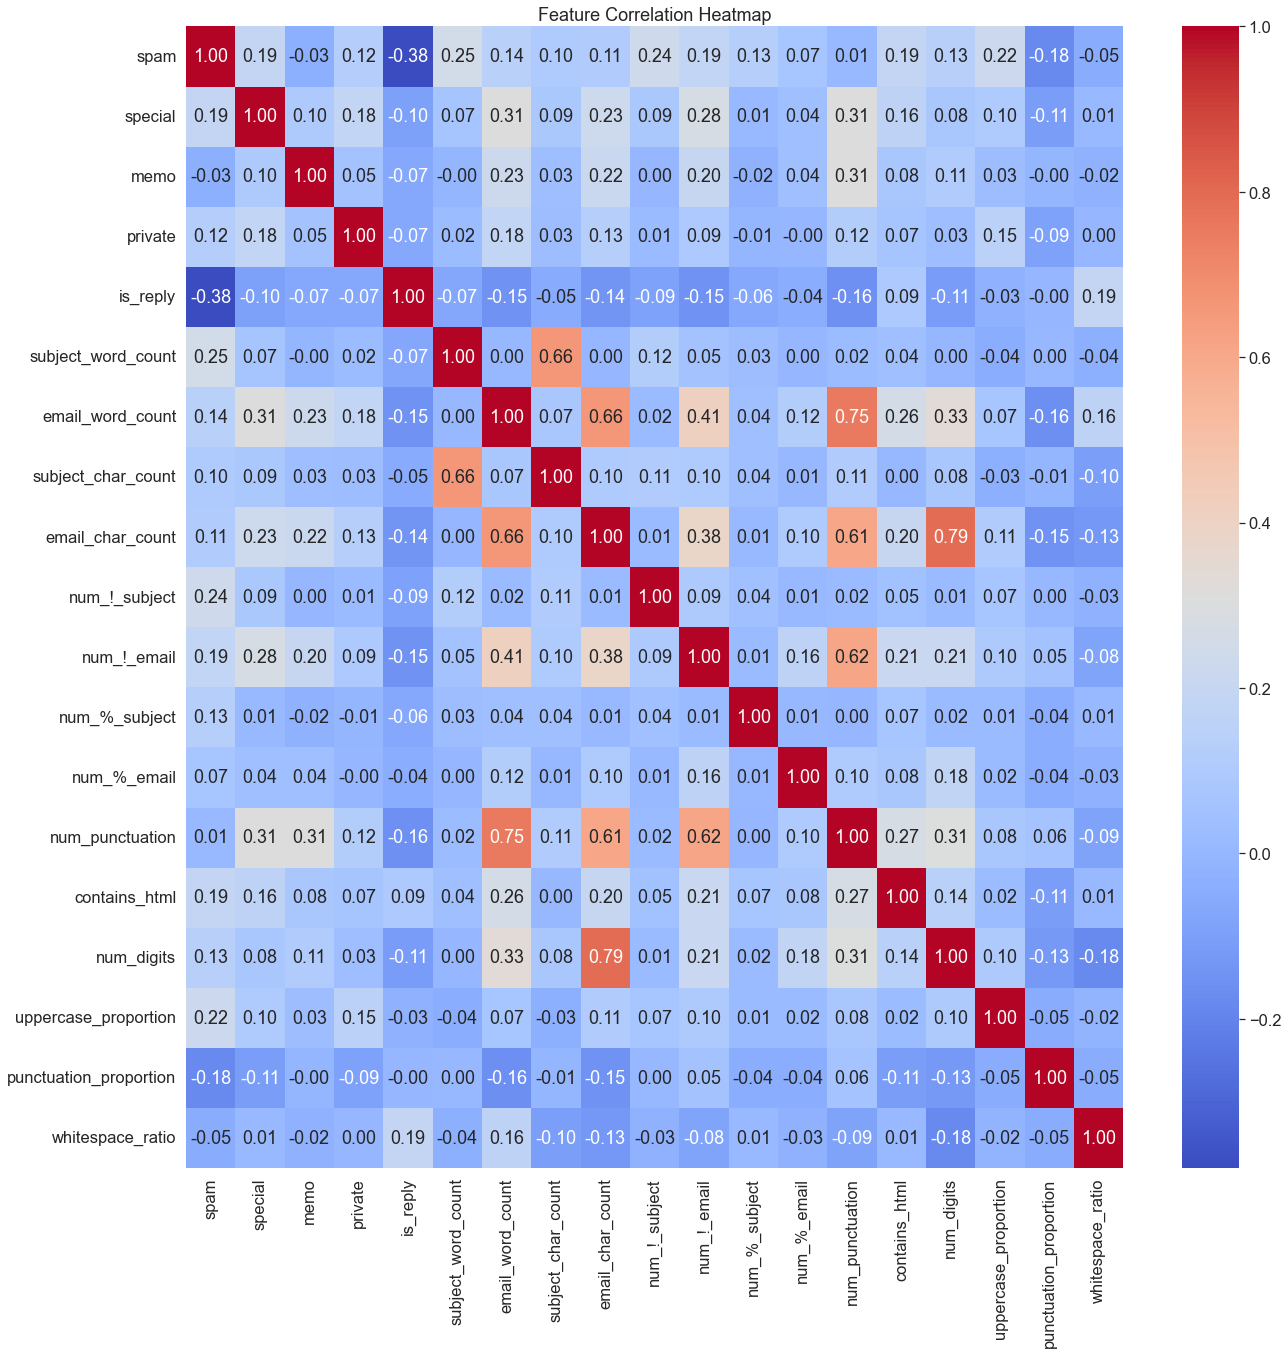

In [21]:
import re

words = ['guarantee', 'best', 'this', 'that', 'link', 'url', 'body', 'html', 'business', 'money', 'offer', 'please', 'special', 'memo', 'private']
word_array = words_in_texts(words, train['email'])
df = pd.DataFrame(word_array, columns=words)

train_feat = train.copy()
df['id'] = train_feat['id']
train_feat = train_feat.merge(df, left_on='id', right_on='id')

train_feat['is_reply'] = train_feat['subject'].str.contains('Re:').astype('int')
train_feat['subject_word_count'] = train_feat['subject'].str.split(' ').str.len()
train_feat['email_word_count'] = train_feat['email'].str.split(' ').str.len()
train_feat['subject_char_count'] = train_feat['subject'].str.len()
train_feat['email_char_count'] = train_feat['email'].str.len()
train_feat['num_!_subject'] = train_feat['subject'].apply(lambda s: len(re.findall(pattern='!', string=s)))
train_feat['num_!_email'] = train_feat['email'].apply(lambda s: len(re.findall(pattern='!', string=s)))
train_feat['num_%_subject'] = train_feat['subject'].apply(lambda s: len(re.findall(pattern='%', string=s)))
train_feat['num_%_email'] = train_feat['email'].apply(lambda s: len(re.findall(pattern='%', string=s)))
train_feat['num_punctuation'] = train_feat['email'].apply(lambda x: sum([1 for char in x if char in '!?.']))
train_feat['contains_html'] = train_feat['email'].str.contains('<.*?>', case=False).astype(int)
train_feat['num_digits'] = train_feat['email'].apply(lambda x: sum(c.isdigit() for c in x))
train_feat['uppercase_proportion'] = train_feat['subject'].apply(lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0)
train_feat['punctuation_proportion'] = train_feat['num_punctuation'] / train_feat['email_char_count']
train_feat['whitespace_ratio'] = train_feat['email'].apply(lambda x: sum(1 for c in x if c.isspace()) / len(x) if len(x) > 0 else 0)

fig, axs = plt.subplots(2, 2, figsize=(15,12))
sns.scatterplot(ax=axs[0,0], x = train_feat['num_%_subject'], y = train_feat['num_%_email'], hue = train_feat['spam'])
axs[0, 0].set_title("Percentage (%) Count")
axs[0, 0].set_xlabel('Subject % Count')
axs[0, 0].set_ylabel('Email % Count')

sns.scatterplot(ax=axs[0,1], x = train_feat['num_!_subject'], y = train_feat['num_!_email'], hue = train_feat['spam'])
axs[0, 1].set_title("Exclamation Count")
axs[0, 1].set_xlabel('Subject Exclamation Count')
axs[0, 1].set_ylabel('Email Exclamation Count')

sns.scatterplot(ax=axs[1,0], x = train_feat['subject_word_count'], y = train_feat['email_word_count'], hue = train_feat['spam']);
axs[1, 0].set_title("Word Count")
axs[1, 0].set_xlabel('Subject Word Count')
axs[1, 0].set_ylabel('Email Word Count')

sns.scatterplot(ax=axs[1,1], x = train_feat['subject_char_count'], y = train_feat['email_char_count'], hue = train_feat['spam']);
axs[1, 1].set_title("Character Count")
axs[1, 1].set_xlabel('Subject Character Count')
axs[1, 1].set_ylabel('Email Character Count')
plt.tight_layout()

replyPlot_table = train_feat.groupby('spam').sum()
plt.figure(figsize=(10, 5))
plt.bar(x=replyPlot_table.index, height=replyPlot_table['is_reply'])
plt.xlabel('Spam')
plt.ylabel('# of Reply Emails')
plt.title('# of Emails Containing \'Re:\'');

# Boxplot to compare spam vs. ham for punctuation_proportion, num_digits, uppercase_proportion
plt.figure(figsize=(10, 5))
sns.boxplot(data=train_feat, x='spam', y='punctuation_proportion')
plt.title("Punctuation Proportion by Email Type (Spam vs. Ham)")
plt.xlabel("Spam (1 = Spam, 0 = Ham)")
plt.ylabel("Punctuation Proportion")
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(data=train_feat, x='spam', y='num_digits')
plt.title("Number of Digits by Email Type (Spam vs. Ham)")
plt.xlabel("Spam (1 = Spam, 0 = Ham)")
plt.ylabel("Number of Digits")
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(data=train_feat, x='spam', y='uppercase_proportion')
plt.title("Uppercase Letter Proportion by Email Type (Spam vs. Ham)")
plt.xlabel("Spam (1 = Spam, 0 = Ham)")
plt.ylabel("Uppercase Letter Proportion")
plt.show()

# Heatmap of correlations
plt.figure(figsize=(21, 21))
correlation_matrix = train_feat[['spam'] + train_feat.columns[16:].to_list()].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show();

<br>

---

## Plot Descriptions and its implications with respect to our features.

The exclamation plot and word count show how ham have generally smaller x values in both plots and larger y values. That means these features may help in predicting weather an email is spam or not. On the other hand, in the feature heatmap, some of the highest correlation between features occur for email character count with number of digits, and email word count with number of punctuation marks. Then there is email character count and number of puctuations. Maybe it would be better to use proportion for one feature and count for its corresponding correlated feature rather than use total counts for both. Overall, it might be a good idea to use PCA and find whatever components cover the most variance.



<br/>
<hr style="border: 4.5px solid teal;" />
<hr style="border: 3.3px solid #10b981;" />   <!-- Emerald -->
<hr style="border: 2.2px solid teal;" />
<hr style="border: 2px solid cornflowerblue;" />
<hr style="border: 5px solid hsl(200, 100%, 50%);" />   <!-- bright blue -->

# 2: Building our Own Model

Now that you've explored the data and relevant features through EDA, it's time to build our model! As mentioned earlier, you may use whatever method you prefer to create features, but **you may only use the packages we've imported for you in the cell below or earlier in this notebook**. In addition, **you are only allowed to train logistic regression models**. No decision trees, random forests, k-nearest-neighbors, neural nets, etc. 

Please consider the ideas mentioned above when choosing features. We have not provided any code to do this, so feel free to create as many cells as you need to tackle this task. 

In [23]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import re
from collections import Counter

In [24]:
import warnings
warnings.filterwarnings("ignore")

words = ['best', 'this', 'that', 'link', 'url', 'body', 'business', 'html', 'money', 'offer', 'please', 'special', 'memo', 'private']
word_array = words_in_texts(words, val['email'])
df = pd.DataFrame(word_array, columns=words)
val = val.reset_index(drop = True)
val_feat = val.copy()
df['id'] = val['id']
print('val_feat:', val_feat.shape)
val_feat = val_feat.merge(df, left_on='id', right_on='id')
print('val_feat:', val_feat.shape)

val_feat['is_reply'] = val_feat['subject'].str.contains('Re:').astype('int')
val_feat['subject_word_count'] = val_feat['subject'].str.split(' ').str.len()
val_feat['email_word_count'] = val_feat['email'].str.split(' ').str.len()
val_feat['subject_char_count'] = val_feat['subject'].str.len()
val_feat['email_char_count'] = val_feat['email'].str.len()
val_feat['num_!_subject'] = val_feat['subject'].apply(lambda s: len(re.findall(pattern='!', string=s)))
val_feat['num_!_email'] = val_feat['email'].apply(lambda s: len(re.findall(pattern='!', string=s)))
val_feat['num_%_subject'] = val_feat['subject'].apply(lambda s: len(re.findall(pattern='%', string=s)))
val_feat['num_%_email'] = val_feat['email'].apply(lambda s: len(re.findall(pattern='%', string=s)))
val_feat['num_punctuation'] = val_feat['email'].apply(lambda x: sum([1 for char in x if char in '!?.']))
val_feat['contains_html'] = val_feat['email'].str.contains('<.*?>', case=False).astype(int)
val_feat['num_digits'] = val_feat['email'].apply(lambda x: sum(c.isdigit() for c in x))
val_feat['uppercase_proportion'] = val_feat['subject'].apply(lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0)
val_feat['punctuation_proportion'] = val_feat['num_punctuation'] / val_feat['email_char_count']
val_feat['whitespace_ratio'] = val_feat['email'].apply(lambda x: sum(1 for c in x if c.isspace()) / len(x) if len(x) > 0 else 0)
print('val_feat:', val_feat.shape)

columns = ['best', 'this', 'that', 'link', 'url', 'body', 'business',
        'html', 'money', 'offer', 'please', 'special', 'memo', 'private',
        'is_reply', 'subject_word_count', 'email_word_count',
        'subject_char_count', 'email_char_count', 'num_!_subject',
        'num_!_email', 'num_%_subject', 'num_%_email', 'num_punctuation',
        'contains_html', 'num_digits', 'uppercase_proportion',
        'punctuation_proportion', 'whitespace_ratio']
features = val_feat[val_feat.columns[4:]]
print('features:', features.shape)

f_mean = np.mean(features, axis=0)
f_std = np.std(features, axis=0)
f_standardized = (features - f_mean)/f_std
f_mean, f_std

lr_model = LogisticRegression()

# Parameter grid with penalty-solver mapping
parameters = [
    {'penalty': ['l1'], 'solver': ['liblinear', 'saga']},
    {'penalty': ['l2'], 'solver': ['lbfgs', 'liblinear', 'newton-cg', 'saga']}
]

# GridSearchCV
grid = GridSearchCV(estimator=lr_model, param_grid=parameters, cv=5)
grid_result = grid.fit(f_standardized, np.array(val['spam']))


print(grid_result.cv_results_['mean_test_score'], grid_result.cv_results_)

val_predictions = grid.best_estimator_.predict(f_standardized)

np.mean(val_predictions == val["spam"])

val_feat: (835, 4)
val_feat: (835, 18)
val_feat: (835, 33)
features: (835, 29)
[0.9005988  0.89820359 0.89700599 0.89580838 0.89700599 0.89700599] {'mean_fit_time': array([0.00523062, 0.01761384, 0.00533118, 0.00355711, 0.0072021 ,
       0.01370273]), 'std_fit_time': array([0.00299407, 0.00180619, 0.00230548, 0.00024332, 0.00223102,
       0.00020425]), 'mean_score_time': array([0.00096521, 0.00098028, 0.00111742, 0.00096955, 0.00105491,
       0.00093865]), 'std_score_time': array([1.18197881e-04, 1.19074135e-04, 2.25118322e-04, 1.77070382e-05,
       1.58927729e-04, 3.46631425e-05]), 'param_penalty': masked_array(data=['l1', 'l1', 'l2', 'l2', 'l2', 'l2'],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_solver': masked_array(data=['liblinear', 'saga', 'lbfgs', 'liblinear', 'newton-cg',
                   'saga'],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype

0.918562874251497

In [25]:
display(val_feat.head())
f_standardized.shape, val["spam"].shape, val_feat.shape, val.shape

,id,subject,email,spam,best,this,that,link,url,body,...,num_!_subject,num_!_email,num_%_subject,num_%_email,num_punctuation,contains_html,num_digits,uppercase_proportion,punctuation_proportion,whitespace_ratio
0,6475,Subject: RE: My brain hurts\n,"> someone tell me a joke, or email me a beer o...",0,0,1,1,0,0,0,...,0,5,0,0,25,0,0,0.142857,0.018769,0.207958
1,4559,Subject: Re: [fwd: error exmh 2.5 07/13/2001 ]\n,--==_exmh_601800448p\n content-type: text/plai...,0,0,1,1,0,0,0,...,0,0,0,0,31,0,120,0.042553,0.014685,0.203221
2,7977,Subject: Re: [ILUG] How to copy some files\n,"on sun, jul 21, 2002 at 01:47:39am +0100, paul...",0,1,1,1,1,0,0,...,0,0,0,5,36,0,36,0.162791,0.014833,0.231562
3,4350,Subject: Re: OpenGL\n,"on thu, 1 aug 2002 17:10:48 +0100, john hinsle...",0,0,1,1,0,0,0,...,0,0,0,0,24,1,28,0.250000,0.021719,0.199095
4,5593,Subject: Re: req: Falcon's eye\n,"on tue, jul 30, 2002 at 12:17:21am +0300, vill...",0,0,0,1,0,0,0,...,0,0,0,0,15,1,33,0.096774,0.019330,0.182990


((835, 29), (835,), (835, 33), (835, 4))

In [26]:
val.head()

,id,subject,email,spam
0,6475,Subject: RE: My brain hurts\n,"> someone tell me a joke, or email me a beer o...",0
1,4559,Subject: Re: [fwd: error exmh 2.5 07/13/2001 ]\n,--==_exmh_601800448p\n content-type: text/plai...,0
2,7977,Subject: Re: [ILUG] How to copy some files\n,"on sun, jul 21, 2002 at 01:47:39am +0100, paul...",0
3,4350,Subject: Re: OpenGL\n,"on thu, 1 aug 2002 17:10:48 +0100, john hinsle...",0
4,5593,Subject: Re: req: Falcon's eye\n,"on tue, jul 30, 2002 at 12:17:21am +0300, vill...",0


In [27]:
# Define our processing function, processed data, and model here. 

import warnings
warnings.filterwarnings("ignore")

def create_features_and_train(train, with_pca=False, test=False):
    words = ['best', 'this', 'that', 'link', 'url', 'body', 'business', 'html', 'money', 'offer', 'please', 'special', 'memo', 'private']
    word_array = words_in_texts(words, train['email'])
    df = pd.DataFrame(word_array, columns=words)

    train = train.reset_index(drop = True)
    
    train_feat = train.copy()
    df['id'] = train_feat['id']
    train_feat = train_feat.merge(df, left_on='id', right_on='id')
    
    train_feat['is_reply'] = train_feat['subject'].str.contains('Re:').fillna(0).astype('int')
    train_feat['subject_word_count'] = train_feat['subject'].str.split(' ').str.len()
    train_feat['email_word_count'] = train_feat['email'].str.split(' ').str.len()
    train_feat['subject_char_count'] = train_feat['subject'].str.len()
    train_feat['email_char_count'] = train_feat['email'].str.len()
    train_feat['num_!_subject'] = train_feat['subject'].apply(lambda s: len(re.findall(pattern='!', string=str(s))))
    train_feat['num_!_email'] = train_feat['email'].apply(lambda s: len(re.findall(pattern='!', string=str(s))))
    train_feat['num_%_subject'] = train_feat['subject'].apply(lambda s: len(re.findall(pattern='%', string=str(s))))
    train_feat['num_%_email'] = train_feat['email'].apply(lambda s: len(re.findall(pattern='%', string=str(s))))
    train_feat['num_punctuation'] = train_feat['email'].apply(lambda x: sum([1 for char in x if char in '!?.']))
    train_feat['contains_html'] = train_feat['email'].str.contains('<.*?>', case=False).astype(int)
    train_feat['num_digits'] = train_feat['email'].apply(lambda x: sum(c.isdigit() for c in x))
    train_feat['uppercase_proportion'] = train_feat['subject'].apply(lambda x: sum(1 for c in str(x) if c.isupper()) / len(str(x)) if len(str(x)) > 0 else 0)
    train_feat['punctuation_proportion'] = train_feat['num_punctuation'] / train_feat['email_char_count']
    train_feat['whitespace_ratio'] = train_feat['email'].apply(lambda x: sum(1 for c in str(x) if c.isspace()) / len(str(x)) if len(str(x)) > 0 else 0)

    columns = ['best', 'this', 'that', 'link', 'url', 'body', 'business',
        'html', 'money', 'offer', 'please', 'special', 'memo', 'private',
        'is_reply', 'subject_word_count', 'email_word_count',
        'subject_char_count', 'email_char_count', 'num_!_subject',
        'num_!_email', 'num_%_subject', 'num_%_email', 'num_punctuation',
        'contains_html', 'num_digits', 'uppercase_proportion',
        'punctuation_proportion', 'whitespace_ratio']
    
    features = train_feat[columns]                    # train_feat[train_feat.columns[4:]]
    features.fillna('')
    f_mean = np.mean(features, axis=0)
    f_std = np.std(features, axis=0)
    f_standardized = (features - f_mean)/f_std
    
    display(f_standardized.head())

    lr_model = LogisticRegression()
    if not test:
        parameters = [
            {'penalty': ['l1'], 'solver': ['liblinear', 'saga']},
            {'penalty': ['l2'], 'solver': ['lbfgs', 'liblinear', 'newton-cg', 'saga']}
            ]
        # GridSearchCV
        grid = GridSearchCV(estimator=lr_model, param_grid=parameters, cv=5)
        grid_result = grid.fit(f_standardized, np.array(train['spam']))
        return grid.best_estimator_, f_standardized
    
    if with_pca:
        pca = PCA(n_components=0.95)
        f_pca = pca.fit_transform(f_standardized)
        print(f"PCA reduced dimensions: {f_pca.shape[1]} components retained.")
        grid_result = grid.fit(f_pca, np.array(train['spam']))
        return grid.best_estimator_, f_pca
    
    return f_standardized



In [28]:
model, standard_train = create_features_and_train(train)
_____, standard_val = create_features_and_train(val)
val_predictions = model.predict(standard_val)

# Print our training accuracy. 
val_accuracy = np.mean(val_predictions == val["spam"])
val_accuracy # 0.9221556886227545

,best,this,that,link,url,body,business,html,money,offer,...,num_!_subject,num_!_email,num_%_subject,num_%_email,num_punctuation,contains_html,num_digits,uppercase_proportion,punctuation_proportion,whitespace_ratio
0,-0.401281,-1.349931,0.775174,-0.455723,-0.511290,-0.538523,-0.387308,-0.681978,-0.338413,-0.380691,...,-0.190827,-0.117128,-0.096806,-0.071868,-0.303692,-0.798456,-0.139674,-0.752991,-0.852326,0.748548
1,-0.401281,0.740779,0.775174,2.194314,1.955839,1.856931,-0.387308,1.466324,-0.338413,-0.380691,...,-0.190827,-0.311299,-0.096806,-0.009042,0.410792,-0.798456,-0.030693,-0.817611,0.297100,-0.480040
2,-0.401281,0.740779,0.775174,2.194314,-0.511290,-0.538523,-0.387308,-0.681978,-0.338413,-0.380691,...,-0.190827,-0.020043,-0.096806,-0.071868,-0.153275,1.252416,-0.177933,-0.737913,0.619332,-0.672967
3,-0.401281,0.740779,0.775174,-0.455723,-0.511290,-0.538523,-0.387308,1.466324,-0.338413,-0.380691,...,1.266170,-0.117128,-0.096806,-0.071868,0.062951,-0.798456,-0.145471,0.354930,-0.509212,0.145456
4,2.492022,-1.349931,0.775174,2.194314,1.955839,1.856931,2.581923,1.466324,-0.338413,2.626805,...,-0.190827,3.960468,-0.096806,0.284144,6.164275,1.252416,1.463735,0.635342,0.533083,-1.191767


,best,this,that,link,url,body,business,html,money,offer,...,num_!_subject,num_!_email,num_%_subject,num_%_email,num_punctuation,contains_html,num_digits,uppercase_proportion,punctuation_proportion,whitespace_ratio
0,-0.370948,0.750780,0.784275,-0.421563,-0.47554,-0.516789,-0.351884,-0.648127,-0.35403,-0.366757,...,-0.250361,0.119723,-0.049,-0.149438,-0.203979,-0.758599,-0.354043,0.064434,0.250236,0.402383
1,-0.370948,0.750780,0.784275,-0.421563,-0.47554,-0.516789,-0.351884,-0.648127,-0.35403,-0.366757,...,-0.250361,-0.229817,-0.049,-0.149438,-0.144980,-0.758599,-0.045376,-0.807370,-0.253295,0.314430
2,2.695798,0.750780,0.784275,2.372126,-0.47554,-0.516789,-0.351884,-0.648127,-0.35403,-0.366757,...,-0.250361,-0.229817,-0.049,0.165984,-0.095813,-0.758599,-0.261443,0.237689,-0.235028,0.840658
3,-0.370948,0.750780,0.784275,-0.421563,-0.47554,-0.516789,-0.351884,-0.648127,-0.35403,-0.366757,...,-0.250361,-0.229817,-0.049,-0.149438,-0.213813,1.318220,-0.282020,0.995679,0.614055,0.237815
4,-0.370948,-1.331948,0.784275,-0.421563,-0.47554,-0.516789,-0.351884,-0.648127,-0.35403,-0.366757,...,-0.250361,-0.229817,-0.049,-0.149438,-0.302312,1.318220,-0.269159,-0.336102,0.319423,-0.061231


0.911377245508982

In [29]:
model, standard_train = create_features_and_train(train)
train_predictions = model.predict(standard_train)

# Print our training accuracy. 
training_accuracy = np.mean(train_predictions == train["spam"])
training_accuracy # 0.9249301211233861 w/L2 0.9259949421003594 wL1, 0.9249301211233861 with best combo

,best,this,that,link,url,body,business,html,money,offer,...,num_!_subject,num_!_email,num_%_subject,num_%_email,num_punctuation,contains_html,num_digits,uppercase_proportion,punctuation_proportion,whitespace_ratio
0,-0.401281,-1.349931,0.775174,-0.455723,-0.511290,-0.538523,-0.387308,-0.681978,-0.338413,-0.380691,...,-0.190827,-0.117128,-0.096806,-0.071868,-0.303692,-0.798456,-0.139674,-0.752991,-0.852326,0.748548
1,-0.401281,0.740779,0.775174,2.194314,1.955839,1.856931,-0.387308,1.466324,-0.338413,-0.380691,...,-0.190827,-0.311299,-0.096806,-0.009042,0.410792,-0.798456,-0.030693,-0.817611,0.297100,-0.480040
2,-0.401281,0.740779,0.775174,2.194314,-0.511290,-0.538523,-0.387308,-0.681978,-0.338413,-0.380691,...,-0.190827,-0.020043,-0.096806,-0.071868,-0.153275,1.252416,-0.177933,-0.737913,0.619332,-0.672967
3,-0.401281,0.740779,0.775174,-0.455723,-0.511290,-0.538523,-0.387308,1.466324,-0.338413,-0.380691,...,1.266170,-0.117128,-0.096806,-0.071868,0.062951,-0.798456,-0.145471,0.354930,-0.509212,0.145456
4,2.492022,-1.349931,0.775174,2.194314,1.955839,1.856931,2.581923,1.466324,-0.338413,2.626805,...,-0.190827,3.960468,-0.096806,0.284144,6.164275,1.252416,1.463735,0.635342,0.533083,-1.191767


0.9239984027685345

In [30]:
model, standard_train = create_features_and_train(train)
standard_test = create_features_and_train(test, test=True)
test_predictions = model.predict(standard_test.fillna(0))

,best,this,that,link,url,body,business,html,money,offer,...,num_!_subject,num_!_email,num_%_subject,num_%_email,num_punctuation,contains_html,num_digits,uppercase_proportion,punctuation_proportion,whitespace_ratio
0,-0.401281,-1.349931,0.775174,-0.455723,-0.511290,-0.538523,-0.387308,-0.681978,-0.338413,-0.380691,...,-0.190827,-0.117128,-0.096806,-0.071868,-0.303692,-0.798456,-0.139674,-0.752991,-0.852326,0.748548
1,-0.401281,0.740779,0.775174,2.194314,1.955839,1.856931,-0.387308,1.466324,-0.338413,-0.380691,...,-0.190827,-0.311299,-0.096806,-0.009042,0.410792,-0.798456,-0.030693,-0.817611,0.297100,-0.480040
2,-0.401281,0.740779,0.775174,2.194314,-0.511290,-0.538523,-0.387308,-0.681978,-0.338413,-0.380691,...,-0.190827,-0.020043,-0.096806,-0.071868,-0.153275,1.252416,-0.177933,-0.737913,0.619332,-0.672967
3,-0.401281,0.740779,0.775174,-0.455723,-0.511290,-0.538523,-0.387308,1.466324,-0.338413,-0.380691,...,1.266170,-0.117128,-0.096806,-0.071868,0.062951,-0.798456,-0.145471,0.354930,-0.509212,0.145456
4,2.492022,-1.349931,0.775174,2.194314,1.955839,1.856931,2.581923,1.466324,-0.338413,2.626805,...,-0.190827,3.960468,-0.096806,0.284144,6.164275,1.252416,1.463735,0.635342,0.533083,-1.191767


,best,this,that,link,url,body,business,html,money,offer,...,num_!_subject,num_!_email,num_%_subject,num_%_email,num_punctuation,contains_html,num_digits,uppercase_proportion,punctuation_proportion,whitespace_ratio
0,2.509835,0.791212,0.804641,-0.484322,-0.515580,1.840099,-0.369274,1.495408,-0.327749,-0.381412,...,-0.233408,-0.325803,-0.084819,-0.163003,0.242812,1.266557,0.079564,0.828272,-0.495979,1.700230
1,-0.398433,-1.263884,-1.242791,-0.484322,-0.515580,-0.543449,-0.369274,-0.668714,-0.327749,2.621834,...,-0.233408,0.434658,-0.084819,-0.103923,-0.124965,-0.789542,-0.262135,0.196781,1.064167,1.200000
2,-0.398433,-1.263884,-1.242791,-0.484322,-0.515580,-0.543449,-0.369274,-0.668714,-0.327749,-0.381412,...,-0.233408,-0.325803,-0.084819,-0.163003,-0.180867,-0.789542,-0.002773,5.118879,-1.821181,-2.979807
3,-0.398433,-1.263884,-1.242791,-0.484322,1.939563,-0.543449,-0.369274,-0.668714,-0.327749,-0.381412,...,-0.233408,-0.325803,-0.084819,-0.163003,-0.177924,-0.789542,-0.278602,-0.792373,-0.730557,-0.240094
4,-0.398433,0.791212,0.804641,-0.484322,-0.515580,-0.543449,-0.369274,-0.668714,-0.327749,-0.381412,...,-0.233408,-0.217166,-0.084819,-0.163003,-0.122022,-0.789542,-0.262135,-0.532451,0.708715,0.063075


<br/>
<hr style="border: 4.5px solid teal;" />
<hr style="border: 3.3px solid #10b981;" />   <!-- Emerald -->
<hr style="border: 2.2px solid teal;" />
<hr style="border: 2px solid cornflowerblue;" />
<hr style="border: 5px solid hsl(200, 100%, 50%);" />   <!-- bright blue -->

# Analyzing our Model




## Describe the process of improving our model. Address the following questions:

1. How did you find better features for our model?
2. What did you try that worked or didn't work?
3. What was surprising in our search for good features?

I tried many different words and looked for the ones in which there was a large difference betwen occurrences in Spam and Ham. I had to take out the word guarantee when it came to the test set because it caused an issue, maybe due to a lack of occurrence. The test set actually gave me a lot of problems. I had to type cast a lot of my features to make the test set work. I also had to figure out how to combine the right penalty with the right solver. I could not just choose L2 or L1, and try each of them because some of the solvers require one or the other. I'm suprised at how much adding the number of digits and proprtions of uppercase characters and wether the email is a reply or not helped. The last one I could've guessed would be a good determiner because noone replies to spam but lots of emails go without replies as is shown by there only being 2500 emails containig 'Re', but it still helped. I was also really shoched by the dramatic difference in occurence between spam and ham for such common words like this and that. I tried implementing PCA using built-in functions but I realized I didnt even need it to get a decent accuracy.

<br>

---

# ROC Curve

In most cases, we won't be able to get 0 false positives and 0 false negatives, so we have to compromise. For example, in the case of cancer screenings, false negatives are comparatively worse than false positives — a false negative means that a patient might not discover that they have cancer until it's too late. In contrast, a patient can receive another screening for a false positive.

Recall that logistic regression calculates the probability that an example belongs to a particular class. To classify an example, we say that an email is spam if our classifier gives it $\ge 0.5$ probability of being spam. However, **we can adjust that cutoff threshold**. We can say that an email is spam only if our classifier gives it $\ge 0.7$ probability of being spam, for example. This is how we can trade off false positives and false negatives.

The Receiver Operating Characteristic (ROC) curve shows this trade-off for each possible cutoff probability. In the cell below, plot an ROC curve for our final classifier on the training data. [Lecture 23](https://ds100.org/fa24/lecture/lec23/) may be helpful.

**Hint**: You'll want to use the `.predict_proba` method [(documentation)](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict_proba) for our classifier instead of `.predict` to get probabilities instead of binary predictions.

Text(0.5, 1.0, 'R.O.C. Curve')

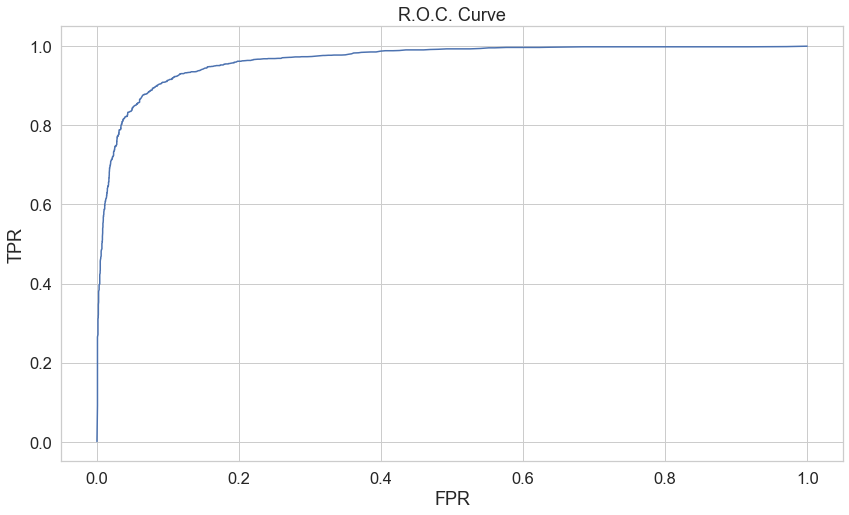

In [31]:
# Define performance metrics dependent on the threshold value.
def predict_threshold(model, X, T): 
    prob_one = model.predict_proba(X)[:, 1]
    return (prob_one >= T).astype(int)

def tpr_threshold(X, Y, T): # Same as recall
    Y_hat = predict_threshold(model, X, T)
    return np.sum((Y_hat == 1) & (Y == 1)) / np.sum(Y == 1)

def fpr_threshold(X, Y, T):
    Y_hat = predict_threshold(model, X, T)
    return np.sum((Y_hat == 1) & (Y == 0)) / np.sum(Y == 0)

metrics = pd.DataFrame()
metrics["Threshold"] = np.linspace(0, 1, 1000)
metrics["TPR"] = [tpr_threshold(standard_train, Y_train, t) for t in metrics["Threshold"]]
metrics["FPR"] = [fpr_threshold(standard_train, Y_train, t) for t in metrics["Threshold"]]

plt.figure(figsize=(14,8))
plt.plot(metrics["FPR"], metrics["TPR"])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('R.O.C. Curve')
#plt.xlim(0,1)
#plt.ylim(0,1)

<br/>
<hr style="border: 4.5px solid teal;" />
<hr style="border: 3.3px solid #10b981;" />   <!-- Emerald -->
<hr style="border: 2.2px solid teal;" />
<hr style="border: 2px solid cornflowerblue;" />
<hr style="border: 5px solid hsl(200, 100%, 50%);" />   <!-- bright blue -->

# Diving Deeper

So far, we’ve been looking at our model through the lens of accuracy. In the next two questions, we'll dive deeper into the complexities of analyzing our model's performance. In particular, we'll ask you to explore some ambiguous cases that can arise, even within the training data itself, and the consequences of misclassification. You may have already come across some of these cases unknowingly when building our model!

To help you better understand some of the challenges that arise with classification, we've selected three emails from the `train` `DataFrame` and provided them below. Each email highlights a different issue that could arise. Skim through each of the emails below before answering part a).

### Example 1

In [32]:
print("spam: " + str(train.loc[5216]["spam"]))
print("\nemail:\n" + train.loc[5216]["email"])


spam: 1

email:
hello you two,
 
 i am so sorry catherine for not writing recently. i have just been vv busybeing a working mother and sometimes it all gets too much you know!! i cannot wait to see you both although we may meet at the airport on the 16/6 as that's the day we're going to france but i will see you both at bronagh's house for her 30th which we're going to on the way back from the airport. i am so excited about seeing you!!! liitle eva ( aine) was born on tuesday
  she is absolutely incredible. poor bronagh is 11 dsays over!!
 sounds like you've been having an amazing time. hope you won't be too depressed to be back!!
 
 lots of love
 
 deirdre
 "justin mason" <jm@jmason.org> wrote:
 
 <  
 <  just a quick note -
 <  
 <  we've decided to go up to annapurna base camp instead of
 <  the jomsom trek - it's a bit more impressive visually
 <  (if a little soggier).   so as of tomorrow morning, ourselves
 <  and our guide bhadra will be leaping like gazelles up 4000-odd
 <  met

### Example 2

In [33]:
print("spam: " + str(train.loc[36]["spam"]))
print("\nemail:\n" + train.loc[36]["email"])

spam: 0

email:
lifetime movie newsletter
 
 this week's movies to watch on lifetime
 
 [ http://www.lifetimetv.com/movies/index.html ]
 
 august 19, 2002
 
 *************************************************************************
 
 coming at you this week...
 
 1) "the secret life of zoey" premiere!
 2) the buzz about the upcoming movie
 3) movies airing this week
 4) big event: a martinez sunday
 5) fun and games
 
 *************************************************************************
 
 "the secret life of zoey" premiere!
 
 take a sneak peek at lifetimes next exciting original movie, "the secret life of zoey" [ http://www.lifetimetv.com/movies/info/move3195.html ], airing on monday, august 19 at 9 pm et/pt. zoey's mom thought she knew everything about her perfect teenage daughter. but when she realizes that her child is addicted to drugs, both of their worlds spin out of control. this dramatic film delves into the topic of teenage drug addiction and features stellar performer

### Example 1

In [34]:
print("spam: " + str(train.loc[1092]["spam"]))
print("\nemail:\n" + train.loc[1092]["email"])

spam: 0

email:
this is a multi part message in mime format.
 
 --_nextpart_1_bvfoditvghtocxfdvjnkcuwblfv
 content-type: text/plain; charset="us-ascii"
 content-transfer-encoding: 7bit
 
 ........... with our telecoms partner bumblebee !
 
 don't get ripped off by expensive hotel, payphone and mobile charges. 
 save, save, save on international calls with ryanair's phone partner. 
 ************************************************************************
 *********
 
 you'll save up to 70% on international phone calls when you use our 
 online phone card.  you can use the card from any phone in any country 
 you visit and you won't have to worry about high phone charges 
 when you call home or the office.
 
 buying a card couldn't be easier and it's totally secure.  simply go to
 http://www.bumblebeecommunications.com/lowcostcalls/  
  to avail of this special offer for ryanair customers.
 
 it's another great deal from ryanair and our online phone 
 partner, bumblebee communications. 


# Discussion On Example Emails:

1. How would you classify the email (e.g., spam or ham), and does this align with the classification provided in the training data? What could be a reason someone would disagree with *our* classification of the email?


Example one does not at all feel like a spam email. It isn't trying to get anything from the recipient or promote anything. I'm not sure who communicates like that by email rather than text anymore, but it just sounds like a friend reaching out informally. It has a lot of spelling or grammar issues. Also has a lot of punctuation, which was more common for non-spam emails according to earlier plots, so my model might have agreed with me which contradicts the provided classification as spam. Some may actually agree that it is spam due to "travelogue mailing list" being noted at the end. If this is from a long chain of conversations from people on a travel mailing list then it really depends on how the person who's inbox this email is in feels about being on this particular email thread.

The other two emails give you the option to unsubscribe, so assuming the recipient subscribed because they wanted these in their inbox, then it would not be spam. But for me personally, this would be spam.

2. As data scientists, we sometimes take the data to be a fixed “ground truth,” establishing the “correct” classification of emails. However, as you might have seen above, some emails can be ambiguous; people may disagree about whether an email is actually spam or ham. How does the ambiguity in our labeled data (spam or ham) affect our understanding of the model's predictions and the way we measure/evaluate our model's performance?

I think this is why it is important to incorporate a veto, or flagging processs so that individuals can make personal decisions on how their own inboxes should be filtered, giving the user some agency in relabeling data, or labeling new incoming data used for periodic retraining. This ambiguity makes our performance metrics somewhat subjective. Even a little arbitrary to a certain extent. I think maybe the only emails we could really agree on being spam, are scam emails and adds or promotional emails from sources we didnt subscribe to. 

<br>
<hr style="border: 4.5px solid teal;" />
<hr style="border: 3.3px solid #10b981;" />   <!-- Emerald -->
<hr style="border: 2.2px solid teal;" />
<hr style="border: 2px solid cornflowerblue;" />
<hr style="border: 5px solid hsl(200, 100%, 50%);" />   <!-- bright blue -->

# Model Interpretability

we explored the instability present in the “ground truth” and how this affects our evaluation of our model. Now, let's start thinking about our model's interpretability and what that means more broadly for an email classification task. A model is considered **interpretable** if **humans can easily understand the reasoning behind its predictions and classifications**.

1. First, let's see if we can understand how our choice of features relates to how a particular email is classified. Let’s take a look at the `simple_model` we provided you earlier that uses 5 features. We have provided the code below for ease of reference. You will examine how a particular feature influences how an email is classified. 

In [35]:
# Simple model introduced at the start of this notebook. 
# Just pay attention to the features.
some_words = ['drug', 'bank', 'prescription', 'memo', 'private']

X_train = words_in_texts(some_words, train['email'])
Y_train = np.array(train['spam'])

simple_model = LogisticRegression()
simple_model.fit(X_train, Y_train);

Pick an email from the training set and assign its index to `email_idx`. Then, find **one** feature used in `simple_model` such that **removing** it changes how that email is classified. Assign this feature to  `feature_to_remove`.

**Hint**: We suggest starting with finding spam emails that contain the features in our model. All the features in our simple model relate to spam emails, thus it is easier to find a spam email + remove a feature to get it to flip classes.

In [36]:
# Use this cell for scratch work when determining `email_idx`
#words = ['best', 'this', 'that', 'link', 'url', 'body', 'business', 'html', 'money', 'offer', 'please', 'special', 'memo', 'private']
#word_array = words_in_texts(words, train['email'])
sample_df = pd.DataFrame(X_train, columns=some_words)

#train = train.reset_index(drop = True)
    
sample_train = train.copy()
sample_df['id'] = sample_train['id']
sample_train = sample_train.merge(sample_df, left_on='id', right_on='id')

#train[train['spam']==1].loc[5,'email']
sample_train[sample_train['spam']==1] # 19-all except memo 7507-bank 7509-bank

,id,subject,email,spam,drug,bank,prescription,memo,private
5,5247,Subject: asap\n,--===_secatt_000_1fuklemuttfusq\n content-type...,1,0,0,0,0,0
13,354,Subject: Re: Your VIP Pass\n,###################################\n \n fre...,1,0,0,0,0,0
15,6449,Subject: wives and girlfriends cheating and wh...,"<table width=""600"" border=""20"" align=""center"" ...",1,0,0,0,0,0
18,5338,Subject: Fw: Offring Membership To 16 Sites Fo...,<html>\n <head>\n </head>\n <body>\n <center>\...,1,0,0,0,0,0
19,5366,"Subject: The Government grants you $25,000!\n",<html>\n <head>\n </head>\n <center>\n <h1>\n ...,1,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...
7502,1685,"Subject: Hi Janet, are you going to call me? ...","<html>\n <body bgcolor=3d""#003300"">\n <p align...",1,0,0,0,0,0
7503,8322,Subject: WWW Form Submission\n,below is the result of your feedback form. it...,1,0,0,0,0,0
7505,4426,Subject: cell phone ring tones 84221111000000\n,"<html>\n <table width=""350"" border=""0"" cellspa...",1,0,0,0,0,0
7507,6265,Subject: MY PLEA FOR ASSISTANCE PLEASE\n,\n mr. ayanda maredi\n department of minerals ...,1,0,1,0,0,0


In [37]:
email_idx = 7507

prob_spam = simple_model.predict_proba(X_train)[:, 1]
initial_prob = prob_spam[email_idx]
initial_class = "spam" if np.round(initial_prob) else "ham"
print(f"\nPredicted probability of being spam: {np.round(initial_prob*100, 2)}%")
print("\nEmail:\n" + train.loc[email_idx]["email"])


Predicted probability of being spam: 55.61%

Email:

 mr. ayanda maredi
 department of minerals and energy
 pretoria, south africa.
 
 
 good morning,
 
 it is my great pleasure to write you this letter on behalf of my colleagues.
 i venture to write to you perhaps you will see it fit to assist my
 colleagues and i in all honesty as we attempt to seek your assistance.
 
 i have decided to seek a confidential co-operation with you in the execution
 of a deal hereunder for the benefit of all parties and hope you will keep it
 confidential because of the nature of this business.
 
 within the department of minerals and energy where i work as a director
 of audit and project implementation, with the co-operation of two other top officials, we
 have in our possession an overdue payment in us funds.
 
 the said funds represent certain percentage of the contract value executed
 on behalf of my department by a foreign contracting firm, which we the officials over-invoiced to the
 amount of us

In [38]:
feature_to_remove = 'bank'

changed_words = some_words.copy()
changed_words.remove(feature_to_remove)

changed_model = LogisticRegression()
X_changed = words_in_texts(changed_words, train['email'])
y = train['spam']
changed_model.fit(X_changed, y)
changed_prob = changed_model.predict_proba(X_changed[[email_idx]])[:,1][0]
changed_class = "spam" if np.round(changed_prob) else "ham"

print(f"Initially classified as {initial_class} (Probability: {np.round(initial_prob*100, 2)}%)")
print(f"Now classified as {changed_class} (Probability: {np.round(changed_prob*100, 2)}%)")

Initially classified as spam (Probability: 55.61%)
Now classified as ham (Probability: 24.33%)


2. Please provide below the index of the email that you removed (`email_idx`). Additionally, in 2-3 sentences, explain why you think the feature you chose to remove changed how our email was classified.

I chose the email at index 7507.

Since this model is very simple with only 5 features, it should be fairly easy to flip, especially if an email is being classified based on one word. All these words were better indicators of spam than ham and this email only contained one of them. Specifically, it only included the word 'bank' yet was still classified as spam. removing 'bank' as a feature meant it no longer contained any of the spam indicator features, therefore, it makes sense that it would flip classification.

3. Now, let's say that instead of working with a small model containing 50-100 features, you're working with a much larger, more accurate model containing 1000 features. In this context, do you think you could easily find a feature that could change an email's classification as you did in part 1? Why or why not?

No, I think it would be much more difficult. Most emails have a lot of words (or other features) that could be used to classify them. If we are using the entirety of the email to predict its classification, it would be very difficult to make it flip from only one of its predictors. There may be some edge case, if we could locate an email based on its spam probability, and length, I would look for the shortest email or email containing the least amount of information with the a classification probability as close as possible to 50% (assuming thats our threshold). Then maybe we could remove one feature and make it flip. But no, it wouldnt be easy.

4. Would you expect this new model to be more or less interpretable than `simple_model`?  
 
     **Note**: A model is considered interpretable if you can easily understand the reasoning behind its predictions and classifications. For example, the model we saw in part a), `simple_model`, is considered interpretable as we can identify which features contribute to an email's classification.

I would expect this larger model to be less interpretable. The more features we use, the harder it is to tell how and why our model is making its predictions, and what set of features contribute the most to those predictions.

5. Now, imagine you’re a data scientist at Meta, developing a text classification model to decide whether to remove certain posts / comments on Facebook. In particular, you’re primarily working on moderating the following categories of content:

    * Hate speech
    * Misinformation 
    * Violence and incitement

    Pick one of these types of content to focus on (or if you have another type you’d like to focus on, feel free to comment on that!). What content would fall under the category you’ve chosen? Refer to Facebook’s [Community Standards](https://transparency.fb.com/policies/community-standards/), which outline what is and isn’t allowed on Facebook. 

**Hate speech** is defined as any form of expression through which speakers intend to vilify, humiliate or incite hatred against a person or group on the basis of race, religion, skin color, sexual identity, gender identity, ethnicity, disability or national origin. some content that would fall under this would be the use of derogetory words aimed at a person's identity whether its gender, racial, religious or sexual identity. This includes degrading comments and harrassing posts where written words are used to disrespect someone's dignity.

6. What are the stakes of misclassifying a post in the context of a social media platform? Comment on what a false positive and false negative means for the category of content you’ve chosen (hate speech, misinformation, or violence and incitement).

The stakes of misclassifying a post in the context of hate speech can be significant. Both false positives and false negatives carry serious implications.
For False Positives (incorrectly classifying a non-hateful post as hate speech) Freedom of expression would be at stake. Removing legitimate posts mistakenly labeled as hate speech can suppress free speech and lead to censorship concerns. Users could feel unfairly targeted or alienated from the platform, potentially reducing trust and engagement. Some backlash like over-moderation could trigger dissatisfaction among users, leading to accusations of bias or unjust enforcement of content policies. Posts discussing sensitive topics, such as activism against discrimination, may sometimes use language that appears inflammatory but is not hateful. Misclassifying such posts could undermine important conversations and efforts to address social issues.
        
False Negatives (Failing to classify hateful content as hate speech) would cause harm to users. Allowing hate speech to remain on the platform can lead to emotional and psychological harm for targeted individuals or communities, and make it an unsafe environment. Hate speech left unmoderated can spread quickly, reinforcing discriminatory or harmful ideologies and inciting further hostility or violence. The platform could also face regulatory scrutiny or lawsuits for failing to adequately address hate speech.